# T-Maze Interactive Simulation

This notebook executes the action-perception loop for a discrete GFE-constrained SSM.

In [1]:
using Pkg
Pkg.activate("../..")
# Pkg.instantiate()

  Activating project at `c:\Simulations\EpistemicMessagePassing`


In [2]:
using LinearAlgebra
using ForneyLab
using Plots
using ForwardDiff: hessian
# using ProgressMeter

# T-maze layout
# [2| |3]
#   | |
#   |1|
#   |4|

include("factor_nodes/discrete_observation.jl")
include("update_rules/discrete_observation.jl")
;

# Algorithm for $t=1$

In [3]:
fg_t1 = FactorGraph()

u = Vector{Variable}(undef, 2)
x = Vector{Variable}(undef, 2)
y = Vector{Variable}(undef, 2)

# Slice k=0
@RV x_0 ~ Categorical(placeholder(:D_t_min, dims=(8,)))
@RV A ~ Dirichlet(placeholder(:A_s, dims=(16,8)))

# Slice k=1
@RV u[1]
@RV x[1] ~ Transition(x_0, u[1])
placeholder(u[1], :u, index=1, dims=(8,8))
DiscreteObservation(x[1], 
                    A,
                    placeholder(:C, dims=(16,), var_id=:C_1),
                    n_factors=8)
# Slice k=2
@RV u[2]
@RV x[2] ~ Transition(x[1], u[2])
placeholder(u[2], :u, index=2, dims=(8,8))
DiscreteObservation(x[2], 
                    A,
                    placeholder(:C, dims=(16,), var_id=:C_2),
                    n_factors=8)
# Algorithm
q_t1 = PosteriorFactorization([x_0; x], A, ids=[:X, :A])
algo_t1 = messagePassingAlgorithm(q_t1, id=:t1, free_energy=true)
code_t1 = algorithmSourceCode(algo_t1, free_energy=true)
eval(Meta.parse(code_t1))
;

# Algorithm for $t=2$

In [4]:
fg_t2 = FactorGraph()

u = Vector{Variable}(undef, 2)
x = Vector{Variable}(undef, 2)
y = Vector{Variable}(undef, 2)

# Slice k=0
@RV x_0 ~ Categorical(placeholder(:D_t_min, dims=(8,)))
@RV A ~ Dirichlet(placeholder(:A_s, dims=(16,8)))

# Slice k=1
@RV u[1]
@RV x[1] ~ Transition(x_0, u[1])
placeholder(u[1], :u, index=1, dims=(8,8))
@RV y[1] ~ Transition(x[1], A)
placeholder(y[1], :y, index=1, dims=(16,))

# Slice k=2
@RV u[2]
@RV x[2] ~ Transition(x[1], u[2])
placeholder(u[2], :u, index=2, dims=(8,8))
DiscreteObservation(x[2], 
                    A,
                    placeholder(:C, dims=(16,), var_id=:C_2),
                    n_factors=8)
# Algorithm
q_t2 = PosteriorFactorization([x_0; x], A, ids=[:X, :A])
algo_t2 = messagePassingAlgorithm(q_t2, id=:t2, free_energy=true)
code_t2 = algorithmSourceCode(algo_t2, free_energy=true)
eval(Meta.parse(code_t2))
;

# Algorithm for $t=3$ (Learning)

In [5]:
fg_t3 = FactorGraph()

u = Vector{Variable}(undef, 2)
x = Vector{Variable}(undef, 2)
y = Vector{Variable}(undef, 2)

# Slice k=0
@RV x_0 ~ Categorical(placeholder(:D_t_min, dims=(8,)))
@RV A ~ Dirichlet(placeholder(:A_s, dims=(16,8)))

# Slice k=1
@RV u[1]
@RV x[1] ~ Transition(x_0, u[1])
placeholder(u[1], :u, index=1, dims=(8,8))
@RV y[1] ~ Transition(x[1], A)
placeholder(y[1], :y, index=1, dims=(16,))

# Slice k=2
@RV u[2]
@RV x[2] ~ Transition(x[1], u[2])
placeholder(u[2], :u, index=2, dims=(8,8))
@RV y[2] ~ Transition(x[2], A)
placeholder(y[2], :y, index=2, dims=(16,))

# Algorithm
q_t3 = PosteriorFactorization([x_0; x], A, ids=[:X, :A])
algo_t3 = messagePassingAlgorithm(q_t3, id=:t3, free_energy=true)
code_t3 = algorithmSourceCode(algo_t3, free_energy=true)
eval(Meta.parse(code_t3))
;

## Action-Perception Loop

In [6]:
α = 0.9; c = 2.0 # Reward probability and utility
S = 30 # Number of simulations

include("helpers.jl")
include("environment.jl")
include("agent_2.jl")

(A, B, C, D) = constructABCD(α, c)
A_0 = constructAPrior() # Construct prior statistics for A

(reset, execute, observe) = initializeWorld(A, B, C, D) # Let there be a world
(infer, act) = initializeAgent(A_0, B, C, D) # Let there be a constrained agent

# Step through the experimental protocol
As = Vector{Matrix}(undef, S) # Posterior statistics for A
Gts = [[Matrix(undef, 4, 4), Vector(undef, 4), undef] for s=1:S] # Free energy values
ats = [Vector{Int64}(undef, 2) for s=1:S] # Actions
ots = [Vector{Vector}(undef, 2) for s=1:S] # Observations (1-of-K)
rs  = Vector{Int64}(undef, S) # Hidden reward positions
for s = 1:S
    rs[s] = reset() # Reset world
    for t = 1:2
        Gts[s][t] = infer(t, ats[s], ots[s])
        ats[s][t] = act(Gts[s][t])
                    execute(ats[s][t])
        ots[s][t] = observe()
    end
    (Gts[s][3], As[s]) = infer(3, ats[s], ots[s]) # Learn
end
;

# Results

In [7]:
using SparseArrays

include("helpers.jl")

dA = sparse(round.(As[S] - A_0, digits=1)) # Inspect difference in observation statistics
dA_1 = dA[1:4, 1:2]
dA_2 = dA[5:8, 3:4]
dA_3 = dA[9:12, 5:6]
dA_4 = dA[13:16, 7:8]

[dA_1 dA_2 dA_3 dA_4]

4×8 SparseMatrixCSC{Float64, Int64} with 12 stored entries:
  ⋅   15.0   ⋅     ⋅    ⋅    ⋅   3.0   ⋅ 
  ⋅   15.0   ⋅     ⋅    ⋅    ⋅    ⋅   3.0
  ⋅     ⋅   1.8   9.2  0.1  0.1   ⋅    ⋅ 
  ⋅     ⋅   0.2  10.8  0.9  0.9   ⋅    ⋅ 

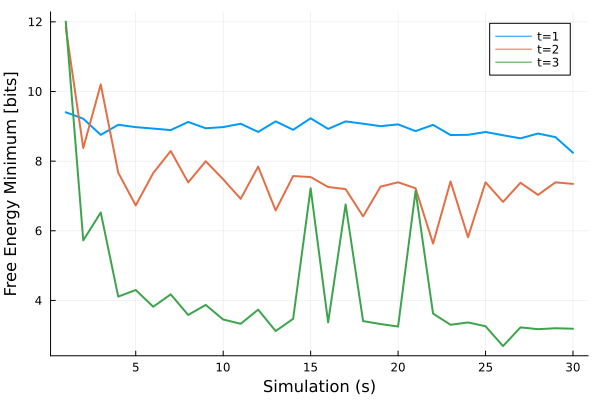

In [8]:
# Plot free energies over simulations
G1_mins = [minimum(skipmissing(Gts[s][1])) for s=1:S]
G2_mins = [minimum(skipmissing(Gts[s][2])) for s=1:S]
G3s = [Gts[s][3] for s=1:S]

plot(1:S, G1_mins, xlabel="Simulation (s)", ylabel="Free Energy Minimum [bits]", label="t=1", lw=2)
plot!(1:S, G2_mins, label="t=2", lw=2)
plot!(1:S, G3s, label="t=3", lw=2)

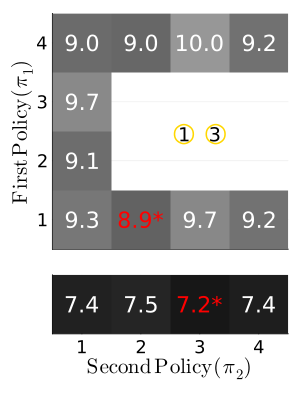

In [35]:
include("visualizations.jl")

s = 21
plotFreeEnergies(Gts[s], ats[s], ots[s], rs[s])